### Для запуска

In [ ]:
import numpy as np
import random 
import matplotlib.pyplot as plt
from torch import nn,manual_seed,from_numpy, split, tensor
import torch.optim as optim
import torch
import time

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Далее идут две функции, которые нужны для перевода данных в тензор.

In [ ]:
def dataConvertor(data,device):
    inputData = []
    outputData = []
    classVectors = []
    for i in data:
        inputData.append(i[0])
        classVectors.append(i[1])
        outputData.append(i[2])
    return  tensor(inputData).to(device),tensor(classVectors).to(device),tensor(outputData).to(device)


def dataBatching(data,batch_len=1):
    inputData =  split(data[0],batch_len)
    classVectors = split(data[1],batch_len)
    outputData = split(data[2],batch_len)
    batchedData = []
    for i in range(len(inputData)):
        batchedData.append([inputData[i],classVectors[i],outputData[i]])
    return batchedData

In [ ]:
load_testData = np.load("/content/gdrive/MyDrive/Data_art_NN/Datasets/forRegression_allClass_test_500000.npy",allow_pickle=True)
load_trainData = np.load("/content/gdrive/MyDrive/Data_art_NN/Datasets/forRegression_allClass_train_500000.npy",allow_pickle=True)

In [ ]:
trainData = dataBatching(dataConvertor(load_trainData,device),500)
testData = dataBatching(dataConvertor(load_testData,device),500)

In [ ]:
for batch,_ in enumerate(testData):
  for i in range(500):
    testData[batch][2][i][1] = (testData[batch][2][i][1]  + torch.tensor(np.pi/2))/np.pi
    testData[batch][2][i][3] = (testData[batch][2][i][3]  + torch.tensor(np.pi/2))/np.pi
    testData[batch][2][i][4] = (testData[batch][2][i][4])/(2*np.pi)
    testData[batch][2][i][5] = (testData[batch][2][i][5]  + torch.tensor(1.))/2
    testData[batch][2][i][6] = (testData[batch][2][i][6])/(2*np.pi)
    trainData[batch][2][i][1] = (trainData[batch][2][i][1]  + torch.tensor(np.pi/2))/np.pi
    trainData[batch][2][i][3] = (trainData[batch][2][i][3]  + torch.tensor(np.pi/2))/np.pi
    trainData[batch][2][i][4] = (trainData[batch][2][i][4])/(2*np.pi)
    trainData[batch][2][i][5] = (trainData[batch][2][i][5]  + torch.tensor(1.))/2
    trainData[batch][2][i][6] = (trainData[batch][2][i][6])/(2*np.pi)


[tensor(0.4201), tensor(0.0208), tensor(0.9665), tensor(0.1097), tensor(0.1746), tensor(0.6495), tensor(0.3985), tensor(0.5002), tensor(0.2312), tensor(0.6515), tensor(0.5577), tensor(0.0541), tensor(0.8643), tensor(0.6504), tensor(0.1162), tensor(0.7374), tensor(0.0096), tensor(0.5300), tensor(0.0713), tensor(0.2704), tensor(0.6355), tensor(0.7839), tensor(0.7065), tensor(0.3558), tensor(0.6860), tensor(0.8940), tensor(0.0340), tensor(0.4359), tensor(0.8887), tensor(0.1268), tensor(0.7846), tensor(0.7029), tensor(0.1682), tensor(0.7664), tensor(0.7704), tensor(0.9217), tensor(0.8428), tensor(0.9576), tensor(0.8348), tensor(0.6653), tensor(0.2295), tensor(0.0390), tensor(0.8698), tensor(0.1688), tensor(0.6625), tensor(0.9468), tensor(0.4337), tensor(0.2473), tensor(0.8747), tensor(0.3379), tensor(0.6277), tensor(0.7498), tensor(0.0877), tensor(0.0227), tensor(0.8363), tensor(0.7133), tensor(0.5076), tensor(0.8806), tensor(0.7723), tensor(0.5784), tensor(0.3737), tensor(0.6410), tensor(

(array([58., 46., 46., 52., 55., 53., 54., 51., 49., 36.]),
 array([0.00116342, 0.10094683, 0.20073023, 0.30051363, 0.40029705,
        0.50008047, 0.5998638 , 0.69964725, 0.79943067, 0.899214  ,
        0.99899745], dtype=float32),
 <a list of 10 Patch objects>)

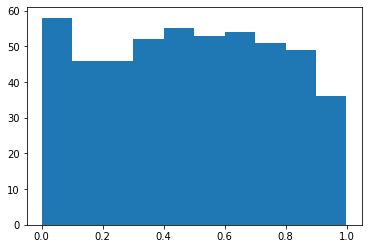

In [ ]:
a = [i[5] for i in trainData[0][2][0:500]]
print(a)
plt.hist(a)

In [ ]:
trainData[0][2].shape

torch.Size([500, 7])

### Сеть

In [ ]:
baseSeq_regression = nn.Sequential(
     nn.Linear(9, 300),
     nn.ReLU(),
     nn.BatchNorm1d(300),
     nn.Linear(300, 3000),
     nn.Dropout(0.6),
     nn.ReLU(),
     nn.BatchNorm1d(3000),
     nn.Linear(3000, 6000),
     nn.Dropout(0.6),
     nn.ReLU(),
     nn.BatchNorm1d(6000),
     nn.Linear(6000, 3000),
     nn.Dropout(0.6),
     nn.ReLU(),
     nn.BatchNorm1d(3000),
     nn.Linear(3000, 1000),
     nn.Dropout(0.6),
     nn.ReLU(),
     nn.BatchNorm1d(1000),
     nn.Linear(1000, 100),
     nn.ReLU(),
     nn.BatchNorm1d(100)
)

In [ ]:
class GPNN_regression(nn.Module):
    def __init__(self, Seq = baseSeq_regression,init_form = 'normal'):
        super().__init__()
        self.layers_stack = Seq
        self.fc_end_T = nn.Linear(100, 7)
        #self.fc_end_LAA = nn.Linear(70, 3)
        #self.fc_end_LPA = nn.Linear(70, 2)
        #self.fc_end_CAA = nn.Linear(70, 7)
        #self.fc_end_CPA = nn.Linear(70, 1)
        self.init_form = init_form
        if self.init_form is not None:
            self.init()

    def forward(self, x):
        x = self.layers_stack(x)
        T = self.fc_end_T(x)
        #LAA = self.fc_end_LAA(x)
        #LPA = self.fc_end_LPA(x)
        #CAA = self.fc_end_CAA(x)
        #CPA = self.fc_end_CPA(x)

        return T #, LAA, LPA, CAA, CPA
        
    def init(self):
        relu_gain = torch.nn.init.calculate_gain("relu")
        for child in self.layers_stack.children():
            if isinstance(child, nn.Linear):
                if self.init_form == "normal":
                    torch.nn.init.kaiming_normal_(child.weight,
                                                 nonlinearity='relu')
                    torch.nn.init.kaiming_normal_(self.fc_end_T.weight,
                                                 nonlinearity='relu')
                    
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                elif self.init_form == "uniform":
                    torch.nn.init.kaiming_uniform_(child.weight,
                                                  nonlinearity='relu')
                    torch.nn.init.kaiming_uniform_(self.fc_end_T.weight,
                                                 nonlinearity='relu')
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                else:
                    raise NotImplementedError()



### Обучение

In [ ]:
def trainGPNN_r(model, trainloader, testloader, device = 'cpu', num_epochs = 2, criterion = nn.MSELoss,\
              optimizer = optim.Adam, learning_rate = 0.001, maxBatch = 10):

    criterion = criterion()
    optimizer = optimizer(model.parameters(), lr=learning_rate)
    num_epochs = num_epochs
    loss_hist = []
    loss_hist_test = []
    acc_test_1,acc_test_2,acc_test_3,acc_test_4 = [],[],[],[]
    acc_train_1,acc_train_2,acc_train_3,acc_train_4 = [],[],[],[]
    for epoch in range(num_epochs):
        hist_loss = 0
        numBatch = 0

        model.train()
        while numBatch < maxBatch:
            corrFunc, classVectors, values = trainloader[numBatch]
            corrFunc, classVectors, values = corrFunc.to(device),\
                      classVectors.to(device), values.to(device)
            optimizer.zero_grad()
            predict = model(corrFunc)
            loss = criterion(predict,values) #lossForRegression(criterion,predict,values,device)
            #loss = lossForRegression(criterion,predict,values,device)
            loss.backward()    
            optimizer.step()
            hist_loss += loss.item()
            numBatch = numBatch + 1
        loss_hist.append(hist_loss /len(trainloader))
      
        model.eval()
        test_loss = 0
        numBatch = 0
        with torch.no_grad():
          while numBatch < maxBatch:
            corrFunc, classVectors, values = testloader[numBatch]
            predict = model(corrFunc)
            loss = criterion(predict,values)
            test_loss += loss.item()
            numBatch = numBatch + 1
        loss_hist_test.append(test_loss/len(testloader))
        #a,b,c,d = calaculate_accuracy_classifier(model,trainloader,device)
        #acc_train_1.append(a);acc_train_2.append(b);acc_train_3.append(c);acc_train_4.append(d)
        #a,b,c,d = calaculate_accuracy_classifier(model,testloader,device)
        #acc_test_1.append(a);acc_test_2.append(b);acc_test_3.append(c);acc_test_4.append(d)
        if epoch%10 == 0: print(f"Epoch={epoch} loss={loss_hist[epoch]:.5f} loss_test={loss_hist_test[epoch]:.5f}")
    return loss_hist, loss_hist_test

In [ ]:
def lossForRegression(criterion,predict,original,device):
  criterion = criterion
  #подготовка к расчету loss функции, переводим данные к нужнмоу формату
  #realT = torch.tensor([[original[0][0]]]).to(device)
  #realLAA = torch.tensor([[original[0][0:2]]]).to(device)
  #realLPA = torch.tensor([[original[0][3:4]]]).to(device)
  loss_1 = []
  for i in original:
     loss_1.append([i[0].item(),i[1].item(),i[2].item(),i[3].item(),i[4].item(),i[5].item(),i[6].item()])
 
  loss_1= torch.tensor(loss_1).to(device)

  total_loss = criterion(predict[3],loss_1)# + criterion(predict[2],realLPA) #criterion(predict[0],loss_1)+2.*criterion(predict[1],loss_2)
  return total_loss


### Запуск Сети

In [ ]:
manual_seed(42)
random.seed(42)
np.random.seed(42)

model = GPNN_regression(init_form = 'uniform').to(device)
model = model.float()
time_0 = time.time()
criterion = nn.L1Loss
loss, loss_test = trainGPNN_r(model,trainData,\
                       testData, criterion = criterion, num_epochs =31, learning_rate = 0.001, device = device, maxBatch = 500)
print("Duration:", time.time()-time_0)

Epoch=0 loss=0.10903 loss_test=0.08464
Epoch=10 loss=0.08187 loss_test=8.85782
Epoch=20 loss=0.07997 loss_test=10.77548
Epoch=30 loss=0.08017 loss_test=6693574.13058
Duration: 230.4968831539154


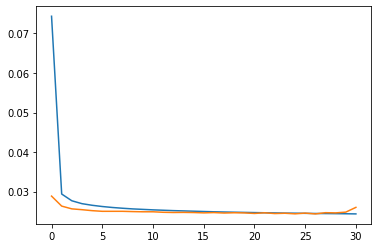

In [ ]:
plt.plot(loss)
plt.plot(loss_test)

In [ ]:
trainData[0][2][10:20]

tensor([[0.1405, 0.7713, 0.4339, 0.2567, 0.0629, 0.2254, 0.9940],
        [0.8633, 0.7021, 0.6677, 0.8090, 0.5382, 0.2764, 0.4892],
        [0.6472, 0.4815, 0.3239, 0.0634, 0.1337, 0.1532, 0.9611],
        [0.2831, 0.6259, 0.7264, 0.3928, 0.0535, 0.3101, 0.9198],
        [0.8876, 0.5130, 0.8597, 0.2498, 0.2677, 0.7376, 0.3520],
        [0.7150, 0.6076, 0.2445, 0.7029, 0.5920, 0.3586, 0.7419],
        [0.3450, 0.4692, 0.5850, 0.0096, 0.3494, 0.9763, 0.6097],
        [0.7488, 0.9635, 0.4245, 0.8069, 0.0397, 0.2295, 0.6808],
        [0.7212, 0.4971, 0.8144, 0.8714, 0.4709, 0.6147, 0.0857],
        [0.3476, 0.5391, 0.9834, 0.3363, 0.5311, 0.1544, 0.1864]],
       device='cuda:0')

In [ ]:
a = [i[4] for i in testData[0][2][0:10]]
print(a)

[tensor(0.7487, device='cuda:0'), tensor(0.3286, device='cuda:0'), tensor(0.8350, device='cuda:0'), tensor(0.1008, device='cuda:0'), tensor(0.5627, device='cuda:0'), tensor(0.5886, device='cuda:0'), tensor(0.1412, device='cuda:0'), tensor(0.2614, device='cuda:0'), tensor(0.4792, device='cuda:0'), tensor(0.9560, device='cuda:0')]


In [ ]:
a = [i[1] for i in trainData[0][2][0:500].to('cpu')]
print(a)
plt.hist(a)

In [ ]:
model.eval()
model(testData[0][0].to(device))[10:20]

tensor([[0.7791, 0.4976, 0.4167, 0.4918, 0.4962, 0.7028, 0.5582],
        [0.8443, 0.4941, 0.2740, 0.4990, 0.4915, 0.9123, 0.5001],
        [0.6278, 0.4931, 0.0903, 0.4983, 0.5032, 0.7217, 0.5489],
        [0.4289, 0.4945, 0.6814, 0.4992, 0.4964, 0.5631, 0.4910],
        [0.6845, 0.4969, 0.6728, 0.4903, 0.4957, 0.5290, 0.5889],
        [0.8779, 0.4920, 0.3970, 0.4986, 0.4953, 0.2550, 0.5564],
        [0.1555, 0.4945, 0.5253, 0.5092, 0.5101, 0.2227, 0.4889],
        [0.6155, 0.4956, 0.3540, 0.4976, 0.4980, 0.6638, 0.5292],
        [0.2074, 0.4985, 0.7126, 0.5040, 0.5012, 0.4380, 0.5723],
        [0.8839, 0.4967, 0.5932, 0.4910, 0.4878, 0.7217, 0.5032]],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [ ]:
#model(testData[0][0].to(device))[0]
testData[0][2][:,0]

In [ ]:
def calaculate_accuracy_regression(model,data,device):
  total_1, total_2 = 0., 0.
  total_3, total_4 = 0., 0.
  total_5,total_6,total_7= 0.0, 0.0, 0.0
  numBatch = 0
  model.eval()
  while numBatch < len(data):
    corrFunc, _, values = data[numBatch]
    numBatch = numBatch + 1
    corrFunc, values = corrFunc.to(device), values.to(device)
    total_1 = total_1 + (abs(model(corrFunc)[:,0]-values[:,0])).mean().item()
    total_2 = total_2 + (abs(model(corrFunc)[:,1]-values[:,1])).mean().item()
    total_3 = total_3 + (abs(model(corrFunc)[:,2]-values[:,2])).mean().item()
    total_4 = total_4 + (abs(model(corrFunc)[:,3]-values[:,3])).mean().item()
    total_5 = total_5 + (abs(model(corrFunc)[:,4]-values[:,4])).mean().item()
    total_6 = total_6 + (abs(model(corrFunc)[:,5]-values[:,5])).mean().item()
    total_7 = total_7 + (abs(model(corrFunc)[:,6]-values[:,6])).mean().item()

  return total_1/len(data),total_2/len(data),total_3/len(data),total_4/len(data),total_5/len(data),total_6/len(data),total_7/len(data)


print(calaculate_accuracy_regression(model,testData,device))
print(calaculate_accuracy_regression(model,trainData,device))



(0.018815196894109248, 0.25213289028406144, 0.037724027764052155, 0.25453245274722575, 0.25043616072833536, 0.028745856078341604, 0.25524666768312454)
(0.018793363492935897, 0.25208011412620546, 0.03771904239431024, 0.2549823703020811, 0.24985801960527898, 0.028639005539938808, 0.2544622203707695)


In [ ]:
testV = trainData[0][2].to(device)
(abs(model(trainData[0][0])[:,0]-testV[:,0])**2).mean().item()

### Для визуализации

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_history(history, n_epochs=5, smooth_val=0.90):
    fig, ax =  plt.subplots(3, 1, figsize=(12, 14))
    for stage_idx, (stage_lbl, stage_title) in enumerate(
        zip(['loss_on_train', 'loss_on_test'],
            ['train loss', 'test loss'])):
        # plot history on each learning step
        epoch_len = len(history[stage_lbl])//n_epochs
        full_stage_len = len(history[stage_lbl])
        ax[stage_idx].plot(exponential_smoothing(history[stage_lbl], smooth_val),
                           label='smoothed',
                           color='m')
        ax[stage_idx].plot(history[stage_lbl],
                           label='raw',
                           alpha=0.2,
                           color='c')
        ax[stage_idx].set_title(stage_title)
        ax[stage_idx].set_xlabel('epochs')
        ax[stage_idx].set_ylabel('loss')
        epochs_ticks_positions = np.arange(stop=full_stage_len+1,
                                           step=epoch_len)
        ax[stage_idx].set_xticks(epochs_ticks_positions)
        ax[stage_idx].set_xticklabels(np.arange(n_epochs+1))
        ax[stage_idx].legend()

        # plot mean train and test loss combined
        mean_loss_on_epoch = [np.mean(history[stage_lbl][i:i+epoch_len]) \
                              for i in range(0, full_stage_len, epoch_len)]
        std_loss_on_epoch = [np.std(history[stage_lbl][i:i+epoch_len]) \
                              for i in range(0, full_stage_len, epoch_len)]

        ax[2].set_title('\nAverage loss per epoch')
        ax[2].errorbar(np.arange(n_epochs) + stage_idx / 30.,
                       mean_loss_on_epoch,
                       yerr=std_loss_on_epoch,
                       capsize=5,
                       fmt="X--",
                       label=stage_title)
        ax[2].set_xticks(np.arange(5))
        ax[2].set_xticklabels(np.arange(5))
        ax[2].set_xlabel('epochs')
        ax[2].set_ylabel('loss')
        ax[2].legend()

    fig.suptitle(history['model_name'], fontsize=24)
    plt.show()